Modified from:

[https://www.tensorflow.org/beta/tutorials/generative/adversarial_fgsm](https://www.tensorflow.org/beta/tutorials/generative/adversarial_fgsm).


GitHub:[link](https://github.com/breemclennan/SIT799/blob/main/Task4_2D_Adversarial_Attacks_on_Computer_Vision.ipynb)

Welcome to your assignment this week! 

To better understand adverse attacks againsts AI and how it is possible to fool an AI system, in this assignment, we will look at a Computer Vision use case. 




This assessment creates an *adversarial example* using the Fast Gradient Signed Method (FGSM) attack as described in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572) by Goodfellow *et al*. This was one of the first and most popular attacks to fool a neural network. 

# What is an adversarial example?

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These notorious inputs are indistinguishable to the human eye, but cause the network to fail to identify the contents of the image. There are several types of such attacks, however, here the focus is on the fast gradient sign method attack, which is a *white box* attack whose goal is to ensure misclassification. A white box attack is where the attacker has complete access to the model being attacked.

# Fast gradient sign method
The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:
$$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   adv_x : Adversarial image.
*   x : Original input image.
*   y : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

An intriguing property here, is the fact that the gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. A method to accomplish this is to find how much each pixel in the image contributes to the loss value, and add a perturbation accordingly. This works pretty fast because it is easy find how each input pixel contributes to the loss, by using the chain rule, and finding the required gradients. Hence, the gradients are used with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. The only goal is to fool an already trained model.



# Part 1

So let's try and fool a pretrained model. In this first part, the model is [MobileNetV2](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/MobileNetV2) model, pretrained on [ImageNet](http://www.image-net.org/).


Run the following cell to install all the packages you will need.

In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

#change directory into file structure
%cd '/content/drive/My Drive/Uni Assignments/SIT799 Human Aligned AI/Task_4'

Mounted at /content/drive
/content/drive/My Drive/Uni Assignments/SIT799 Human Aligned AI/Task_4


In [2]:
 ! pip3 install cython
 ! pip3 install tensornets
 ! pip3 install numpy==1.16.1
 ! pip3 install tensorflow
 ! pip3 install matplotlib

     |████████████████████████████████| 651 kB 6.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for tensornets: filename=tensornets-0.4.6-cp37-cp37m-linux_x86_64.whl size=1191854 sha256=71f0aac1761fdf7c16d6b330a63d4277ccfee1d2d5a0bd12f684d54c9c4c1eb2
  Stored in directory: /root/.cache/pip/wheels/0a/55/2c/eec69a6e382f98e970daf5aebb9e94e4bc2d3bd2b0eff83d26
Successfully built tensornets
     |████████████████████████████████| 17.3 MB 124 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.18.2 requires numpy>=1.17, but you have numpy 1.16.1 which is incompatibl

     |████████████████████████████████| 14.8 MB 176 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.1
    Uninstalling numpy-1.16.1:
      Successfully uninstalled numpy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Run the following cell to load the packages you will need.

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensornets as nets

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
config.allow_soft_placement = True
sess = tf.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



Let's define the computation graph.

In [5]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = image /  127.5
    image = image - 1.0
    image = image[None, ...]
    return image
def reverse_preprocess(image):
    image = image + 1.0
    image = image / 2.0
    return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=5)[0]

# Lets's import an image to process.
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_png(image_raw)
input_image = preprocess(image)
reversed_image = reverse_preprocess(input_image)

input_image_placeholder = tf.placeholder(shape=[1, 224, 224, 3], dtype=tf.float32)

#load the pretrained MobileNetV2 model and the ImageNet class names.
pretrained_model = nets.MobileNet50v2(input_image_placeholder, reuse=tf.AUTO_REUSE)

# node to load pretrained weights
pretrained_ops = pretrained_model.pretrained()

# decode predicted probabilities to ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

90112/83281 [================================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


8019968/8012166 [==============================] - 0s 0us/step


## Original image
Let's use a sample image of a [Labrador Retriever](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg) -by Mirko       [CC-BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/) from Wikimedia Common and create adversarial examples from it. The first step is to preprocess it so that it can be fed as an input to the MobileNetV2 model.

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)

sess.run(pretrained_ops)
preprocessed_img, reversed_img = sess.run([input_image, reversed_image])
image_probs = sess.run([pretrained_model], {input_image_placeholder:preprocessed_img})

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



Let's have a look at the image.

['Labrador_retriever', 'Ibizan_hound', 'Saluki', 'Chesapeake_Bay_retriever', 'Weimaraner']


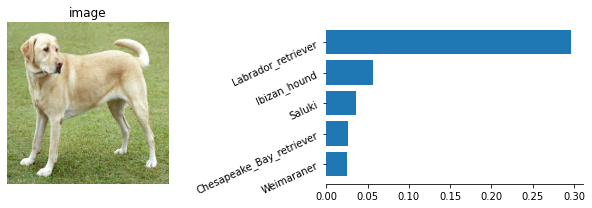

In [ ]:
top5 = get_imagenet_label(image_probs[0])
tick_names = [x[1] for x in top5]
print(tick_names)
probs = [x[2] for x in top5]
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.imshow(reversed_img[0])
plt.title('image')
ax = plt.gca()
ax.axis('off')

plt.subplot(122)
tick_names = [x[1] for x in reversed(top5)]
probs = [x[2] for x in reversed(top5)]
plt.barh(tick_names, probs)
plt.yticks(rotation=25)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
#Decode predictions
from keras.applications.imagenet_utils import decode_predictions
preds = image_probs[0]
print('Predicted:', decode_predictions(preds, top=10))

Predicted: [[('n02099712', 'Labrador_retriever', 0.29645857), ('n02091244', 'Ibizan_hound', 0.05630545), ('n02091831', 'Saluki', 0.03565449), ('n02099849', 'Chesapeake_Bay_retriever', 0.02573056), ('n02092339', 'Weimaraner', 0.024493417), ('n02091134', 'whippet', 0.021611294), ('n02088364', 'beagle', 0.021401467), ('n02110806', 'basenji', 0.015970191), ('n02110958', 'pug', 0.014488043), ('n02089867', 'Walker_hound', 0.014174776)]]


# Create the adversarial image

## Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

**TASK 1:** Implement `create_adversarial_pattern()`. You will need to carry out 3 steps:

1. Create a loss object using `loss_object` using two arguments: `pretrained_model` and `input_label`.
2. Get the gradients using `tf.gradients` of the `loss`  w.r.t to the `input_image`.
3. Get the sign of the gradients to create the perturbation using `tf.sign`.


In [7]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  ## START YOUR CODE HERE (3 lines)
  #1. Create a loss object using loss_object using two arguments: pretrained_model and input_label.
  loss = loss_object(input_label, pretrained_model)
  #2. Get the gradients using tf.gradients of the loss w.r.t to the input_image.
  gradient = tf.gradients(loss, input_image)
  #3. Get the sign of the gradients to create the perturbation using tf.sign.
  signed_grad = tf.sign(gradient)

  return signed_grad[0]

The resulting perturbations can also be visualised.

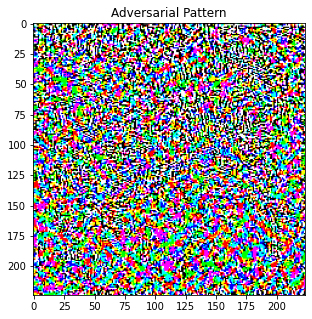

In [ ]:
perturbations = create_adversarial_pattern(input_image_placeholder, tf.argmax(pretrained_model,1))
p_cliped = tf.clip_by_value(perturbations, 0, 1)

p_cliped_val = sess.run(p_cliped, {input_image_placeholder: preprocessed_img})
plt.figure(figsize=(5,5))
plt.imshow(p_cliped_val[0])
#plt.gca().axis('off')
plt.title('Adversarial Pattern')
plt.show()

## Fool the AI system

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network, however, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [8]:
def display_images(image, description):
  rev_image = reverse_preprocess(image)
  adv_img, raw_adv_img = sess.run([image, rev_image], {input_image_placeholder: preprocessed_img})
  img_probs = sess.run(pretrained_model, {input_image_placeholder: adv_img})
  top5 = get_imagenet_label(img_probs)
  top5 = list(reversed(top5))
  plt.figure(figsize=(9, 3))
  plt.subplot(121)
  plt.imshow(raw_adv_img[0])
  plt.title(description)
  plt.gca().axis('off')
  plt.subplot(122)
  tick_names = [x[1] for x in top5]
  probs = [x[2] for x in top5]
  plt.barh(tick_names, probs)
  plt.yticks(rotation=25)
  ax = plt.gca()
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  plt.tight_layout()
  plt.show()

**TASK 2:** Generate adverse image using different values for $\epsilon$:

- adv_x = input_image + $\epsilon$ * perturbations


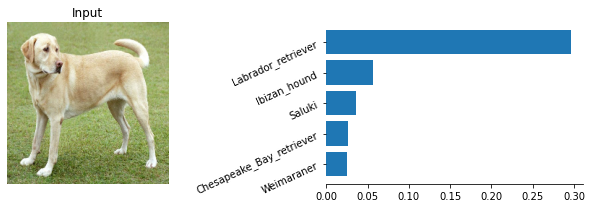

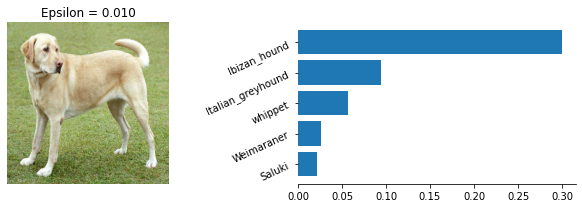

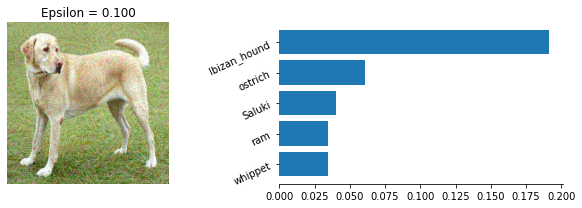

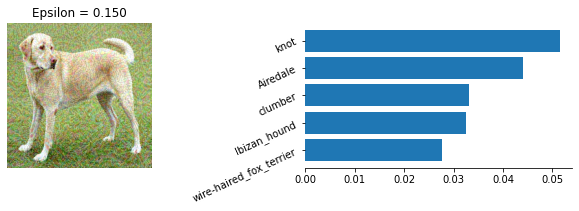

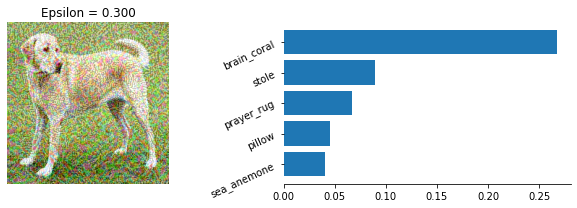

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15, 0.3]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    ## START YOU CODE HERE
    adv_x = input_image + eps * perturbations
    ## End
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])

**TASK 3: What do you abserve?**

***
The original and unmodified input image is correctly classified by the computer vision system. Labrador_retriever is the highest probable class at 0.30 and by a significant margin of approximately 0.25 to the next probable classes. The next 4 highest probable classifications of other dog breeds are Ibizian hound, saluki, Chesapeake bay retriever and Weimaraner. The computer vision model has identified breeds of dog for the top 5 probable classes.

As the level of noise increases (increased epsilons) and introduces distortions to the input image, the correct classification of "Labrador_retriver" is no longer predicted within the top 5 probable classes. The top 5 probable classes begin to deviate away from the correct classification and list other (incorrect) dog-breeds, other animal species and at the last iteration of Epsilon at 0.300, seemingly random objects such as "prayer_rug" and "pillow".

To summarise the observations at each iteration of distortion (epsilon):

1. 0.000: Model correctly predicts "Labrador_retriever" with approx 0.30 probability
2. 0.010: Model incorrectly predicts "Ibizan Hound" with approx 0.30 probability
3. 0.100: Model incorrectly predicts "Ibizan Hound" with approx 0.19 probability
4. 0.150: Model incorrectly predicts "knot" with approx 0.05 probability
5. 0.300: Model incorrectly predicts "brain_coral" with approx 0.27 probability

From a human eye perspective, with the distortion introduced it is still possible to identify the input image is of a Labrador_Retriever, however to the computer vision system (model) the small amount of perceivable distortion is considered a significant data point which can greatly confuse the model.
***

#  Part 2

Here, you are required to process adversarial attacks using FGSM for a small subset of [ImageNet Dataset](http://www.image-net.org/). We prepared 100 images from different categories (in `./input_dir/`), and the labels are encoded in `./input_dir/clean_image.list`.

For evaluation, each adversarial image generated by the attack model will be fed to an evaluation model, and we will calculate the successful rate of adversarial attacks. **The adversarial images that can fool the evaluation model with $\epsilon$ = 0.01 will be considered as a success**.



**Task 4: Goal**

***

With the previous FGSM example, you are required to implement an FGSM attack against all examples and calculate the success rate. Also, display the original image with the attacked image as well as the predicted class for each image.


In [9]:
import os
from tqdm import tqdm # Progress bar
import pandas as pd
import keras
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

#Read in and inspect the clean_image list and image labels
f = open('input_dir/clean_image.list', "r")
clean_image_list = f.read().splitlines()
columns = ['FileName', 'label']
clean_image_list_data = [[str(x) for x in e.split()] for e in clean_image_list]
clean_image_list_df = pd.DataFrame(clean_image_list_data, columns=columns)
print(clean_image_list_df)

          FileName label
0   n02708093.JPEG   409
1   n03000134.JPEG   489
2   n03384352.JPEG   561
3   n03777754.JPEG   662
4   n03721384.JPEG   642
..             ...   ...
95  n02109525.JPEG   247
96  n07697313.JPEG   933
97  n02489166.JPEG   376
98  n02794156.JPEG   426
99  n04131690.JPEG   773

[100 rows x 2 columns]


In [10]:
#read all the training images, store them in a list, and convert that list into a numpy array
train_image = []
input_image_placeholder = tf.placeholder(shape=[1, 224, 224, 3], dtype=tf.float32)

for i in tqdm(range(clean_image_list_df.shape[0])):
    img = image.load_img('input_dir/'+clean_image_list_df['FileName'][i], target_size=(28,28,1), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 100/100 [00:32<00:00,  3.06it/s]


In [11]:
# Refresh the session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
config.allow_soft_placement = True
sess = tf.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [12]:
#Call in the pre trained imagenet model
pretrained_model = nets.MobileNet50v2(input_image_placeholder, reuse=tf.AUTO_REUSE)
# node to load pretrained weights
pretrained_ops = pretrained_model.pretrained()
# decode predicted probabilities to ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [13]:
#Refresh the session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)
sess.run(pretrained_ops)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



[array([[[[ 4.57077213e-02, -8.57395752e-23,  1.00268893e-01,
           -3.07431994e-22, -4.11986150e-02, -2.11578667e-22,
           -1.07591309e-01,  8.08667541e-02,  8.44188705e-02,
           -3.40272488e-22, -2.79563159e-01, -1.60462856e-02,
           -8.86109099e-02,  2.46329024e-01,  3.41672748e-02,
           -1.15300223e-01],
          [-2.26754487e-01, -5.33430218e-22,  9.81049538e-02,
           -5.32021779e-22, -1.63475260e-01,  7.08409336e-23,
           -8.77554789e-02,  1.46926120e-01,  1.49210334e-01,
            1.12386451e-22,  2.10847512e-01, -2.96828784e-02,
            1.89153269e-01,  3.60365868e-01,  1.95388347e-02,
            7.41393343e-02],
          [ 1.23080891e-02,  3.46418201e-23, -6.12633713e-02,
           -4.10532959e-22,  1.25564882e-04,  2.57504697e-22,
            2.01128889e-04,  2.11769491e-02,  1.18617833e-01,
           -3.94013707e-22,  7.88719654e-02, -4.31827968e-03,
           -1.07191585e-01,  1.44435987e-01, -5.67019545e-02,
            

In [14]:
#Prepare data
idx2label = clean_image_list_df['label']
idx2label

0     409
1     489
2     561
3     662
4     642
     ... 
95    247
96    933
97    376
98    426
99    773
Name: label, Length: 100, dtype: object

In [15]:
#Set the root 
%cd '/content/drive/My Drive/Uni Assignments/SIT799 Human Aligned AI/Task_4/'

#Read in the image files using glob
import glob
image_files_collection = glob.glob('input_dir/*.JPEG')
image_files_collection = np.char.strip(image_files_collection, chars='input_dir')
image_files_collection = np.char.strip(image_files_collection, chars='/')
image_files_collection

/content/drive/My Drive/Uni Assignments/SIT799 Human Aligned AI/Task_4


array(['n03384352.JPEG', 'n01773157.JPEG', 'n04606251.JPEG',
       'n09332890.JPEG', 'n03873416.JPEG', 'n04398044.JPEG',
       'n07697313.JPEG', 'n04023962.JPEG', 'n03207941.JPEG',
       'n04536866.JPEG', 'n02326432.JPEG', 'n03063599.JPEG',
       'n02095889.JPEG', 'n01443537.JPEG', 'n04049303.JPEG',
       'n02086240.JPEG', 'n02129604.JPEG', 'n01955084.JPEG',
       'n07717556.JPEG', 'n02704792.JPEG', 'n02655020.JPEG',
       'n07754684.JPEG', 'n03109150.JPEG', 'n02109525.JPEG',
       'n02444819.JPEG', 'n04548280.JPEG', 'n01877812.JPEG',
       'n02708093.JPEG', 'n03777754.JPEG', 'n09399592.JPEG',
       'n03160309.JPEG', 'n04590129.JPEG', 'n07831146.JPEG',
       'n01829413.JPEG', 'n02018207.JPEG', 'n04131690.JPEG',
       'n02815834.JPEG', 'n03485407.JPEG', 'n03467068.JPEG',
       'n04311174.JPEG', 'n04065272.JPEG', 'n03794056.JPEG',
       'n04376876.JPEG', 'n03379051.JPEG', 'n02071294.JPEG',
       'n03424325.JPEG', 'n03216828.JPEG', 'n07836838.JPEG',
       'n03201208.JPEG',

In [18]:
#Intialise lists to hold for-loop iteration results
output = []     #Actuals
output2 = []    #Attack Results
epsilon = 0.01  #Set the distortion amount in an attempt to confuse the model

/content/drive/My Drive/Uni Assignments/SIT799 Human Aligned AI/Task_4/input_dir


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Actual Class: n03384352.JPEG [[('n03384352', 'forklift', 0.8654895)]]
Class for Attacked Image: [('n03018349', 'china_cabinet', 0.35906607)]


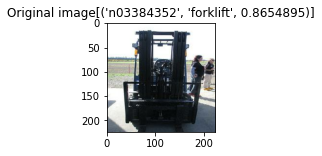

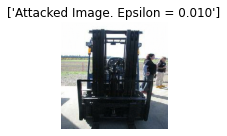

Actual Class: n01773157.JPEG [[('n01773157', 'black_and_gold_garden_spider', 0.7703063)]]
Class for Attacked Image: [('n01773157', 'black_and_gold_garden_spider', 0.32764423)]


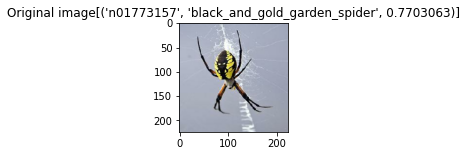

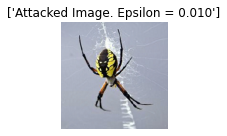

Actual Class: n04606251.JPEG [[('n04606251', 'wreck', 0.97187287)]]
Class for Attacked Image: [('n02105251', 'briard', 0.06528279)]


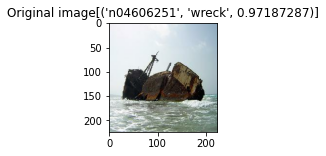

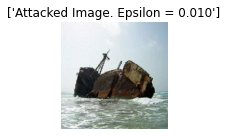

Actual Class: n09332890.JPEG [[('n09332890', 'lakeside', 0.25412458)]]
Class for Attacked Image: [('n02094114', 'Norfolk_terrier', 0.06154018)]


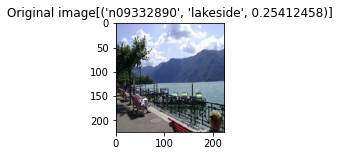

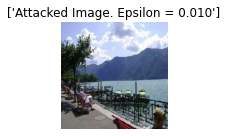

Actual Class: n03873416.JPEG [[('n03873416', 'paddle', 0.93348676)]]
Class for Attacked Image: [('n02071294', 'killer_whale', 0.056280673)]


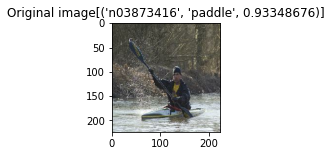

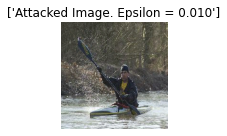

Actual Class: n04398044.JPEG [[('n04398044', 'teapot', 0.9446872)]]
Class for Attacked Image: [('n03063689', 'coffeepot', 0.57923144)]


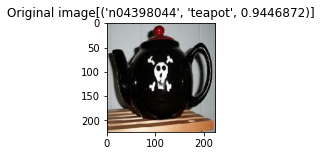

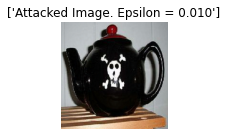

Actual Class: n07697313.JPEG [[('n07697313', 'cheeseburger', 0.88924074)]]
Class for Attacked Image: [('n07716906', 'spaghetti_squash', 0.15732625)]


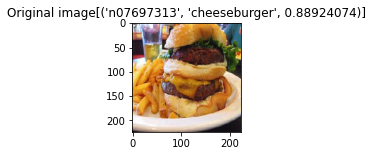

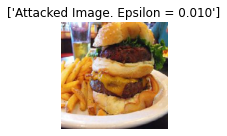

Actual Class: n04023962.JPEG [[('n04023962', 'punching_bag', 0.99856704)]]
Class for Attacked Image: [('n04336792', 'stretcher', 0.10976796)]


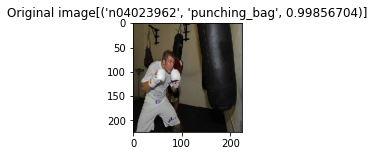

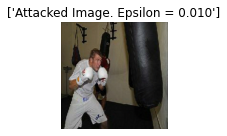

Actual Class: n03207941.JPEG [[('n03207941', 'dishwasher', 0.74007475)]]
Class for Attacked Image: [('n04258138', 'solar_dish', 0.27491954)]


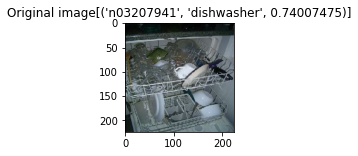

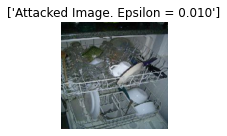

Actual Class: n04536866.JPEG [[('n04536866', 'violin', 0.878774)]]
Class for Attacked Image: [('n04086273', 'revolver', 0.17946446)]


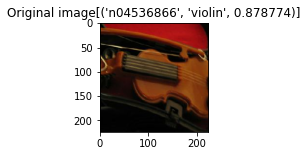

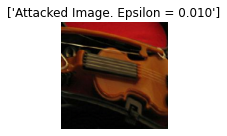

Actual Class: n02326432.JPEG [[('n02326432', 'hare', 0.86773294)]]
Class for Attacked Image: [('n02096294', 'Australian_terrier', 0.06457047)]


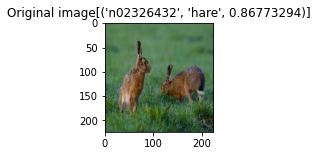

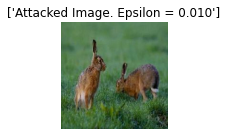

Actual Class: n03063599.JPEG [[('n07930864', 'cup', 0.2917303)]]
Class for Attacked Image: [('n02795169', 'barrel', 0.1405163)]


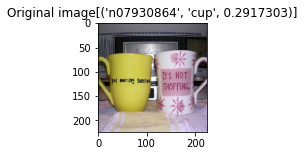

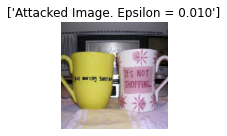

Actual Class: n02095889.JPEG [[('n02095889', 'Sealyham_terrier', 0.95277464)]]
Class for Attacked Image: [('n02100735', 'English_setter', 0.2753337)]


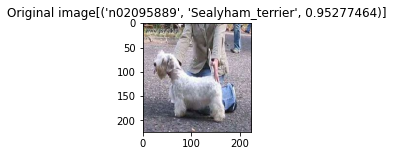

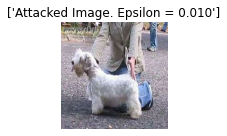

Actual Class: n01443537.JPEG [[('n01443537', 'goldfish', 0.4532124)]]
Class for Attacked Image: [('n03991062', 'pot', 0.038173974)]


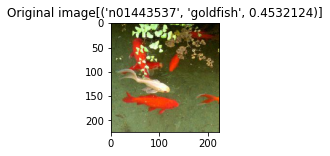

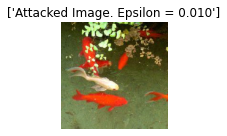

Actual Class: n04049303.JPEG [[('n04049303', 'rain_barrel', 0.9690007)]]
Class for Attacked Image: [('n03160309', 'dam', 0.0634558)]


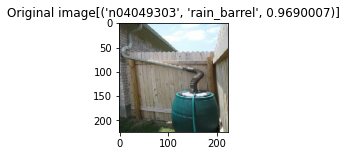

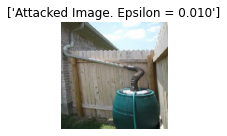

Actual Class: n02086240.JPEG [[('n02086240', 'Shih-Tzu', 0.89104635)]]
Class for Attacked Image: [('n02098413', 'Lhasa', 0.26804048)]


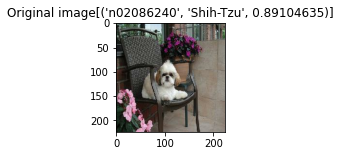

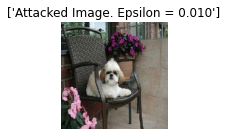

Actual Class: n02129604.JPEG [[('n02129604', 'tiger', 0.56407386)]]
Class for Attacked Image: [('n03404251', 'fur_coat', 0.4097262)]


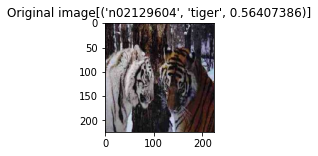

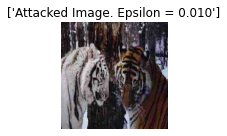

Actual Class: n01955084.JPEG [[('n01955084', 'chiton', 0.84393674)]]
Class for Attacked Image: [('n01990800', 'isopod', 0.9623536)]


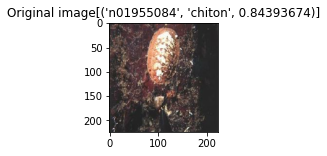

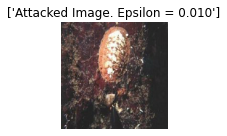

Actual Class: n07717556.JPEG [[('n07717556', 'butternut_squash', 0.97656506)]]
Class for Attacked Image: [('n07584110', 'consomme', 0.2046614)]


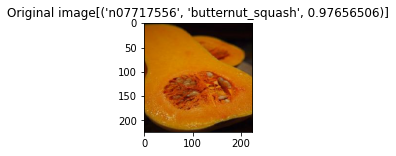

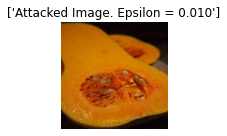

Actual Class: n02704792.JPEG [[('n02704792', 'amphibian', 0.3458817)]]
Class for Attacked Image: [('n09332890', 'lakeside', 0.5300762)]


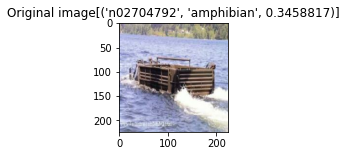

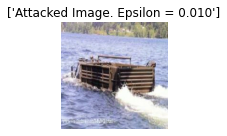

Actual Class: n02655020.JPEG [[('n02655020', 'puffer', 0.76946145)]]
Class for Attacked Image: [('n01748264', 'Indian_cobra', 0.06682701)]


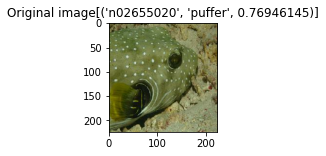

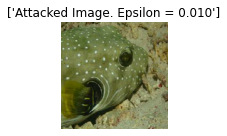

Actual Class: n07754684.JPEG [[('n07754684', 'jackfruit', 0.9760585)]]
Class for Attacked Image: [('n13052670', 'hen-of-the-woods', 0.45723745)]


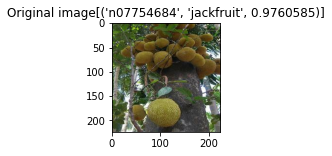

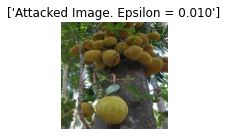

Actual Class: n03109150.JPEG [[('n03109150', 'corkscrew', 0.91712385)]]
Class for Attacked Image: [('n03255030', 'dumbbell', 0.27612188)]


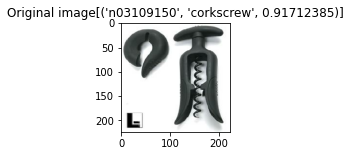

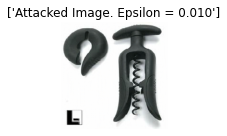

Actual Class: n02109525.JPEG [[('n02109525', 'Saint_Bernard', 0.86261827)]]
Class for Attacked Image: [('n02100735', 'English_setter', 0.022421245)]


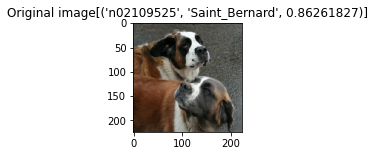

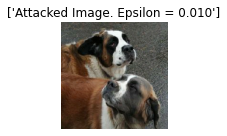

Actual Class: n02444819.JPEG [[('n02444819', 'otter', 0.8649098)]]
Class for Attacked Image: [('n02077923', 'sea_lion', 0.10712063)]


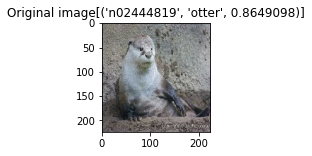

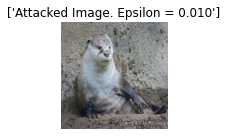

Actual Class: n04548280.JPEG [[('n04548280', 'wall_clock', 0.2546146)]]
Class for Attacked Image: [('n04522168', 'vase', 0.08356504)]


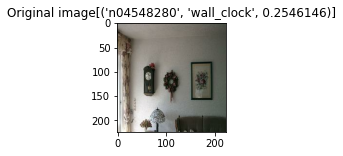

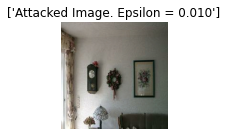

Actual Class: n01877812.JPEG [[('n01877812', 'wallaby', 0.92661804)]]
Class for Attacked Image: [('n02325366', 'wood_rabbit', 0.16495717)]


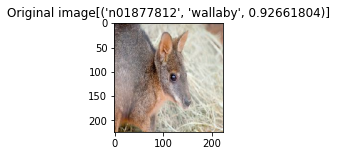

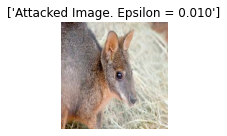

Actual Class: n02708093.JPEG [[('n02708093', 'analog_clock', 0.3404644)]]
Class for Attacked Image: [('n03492542', 'hard_disc', 0.15921755)]


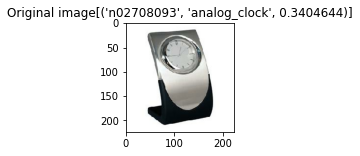

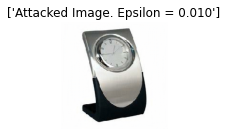

Actual Class: n03777754.JPEG [[('n03777754', 'modem', 0.74445724)]]
Class for Attacked Image: [('n04517823', 'vacuum', 0.29836994)]


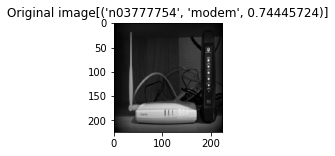

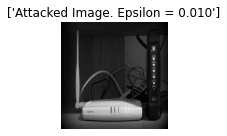

Actual Class: n09399592.JPEG [[('n09399592', 'promontory', 0.750695)]]
Class for Attacked Image: [('n09428293', 'seashore', 0.1820343)]


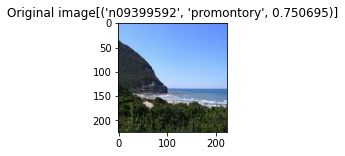

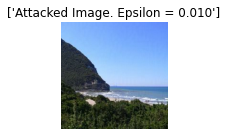

Actual Class: n03160309.JPEG [[('n03160309', 'dam', 0.8289476)]]
Class for Attacked Image: [('n03792972', 'mountain_tent', 0.36943066)]


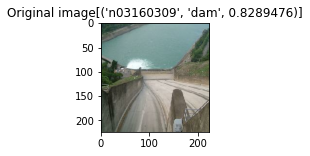

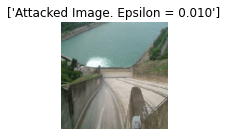

Actual Class: n04590129.JPEG [[('n04590129', 'window_shade', 0.8538884)]]
Class for Attacked Image: [('n04239074', 'sliding_door', 0.5881913)]


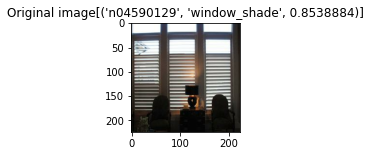

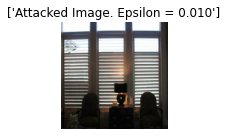

Actual Class: n07831146.JPEG [[('n07831146', 'carbonara', 0.88734657)]]
Class for Attacked Image: [('n07880968', 'burrito', 0.102502726)]


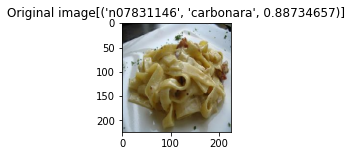

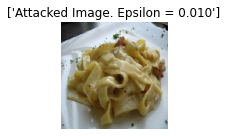

Actual Class: n01829413.JPEG [[('n01829413', 'hornbill', 0.99131924)]]
Class for Attacked Image: [('n01829413', 'hornbill', 0.028246596)]


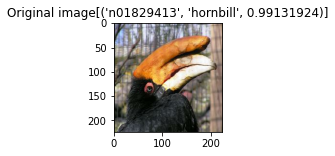

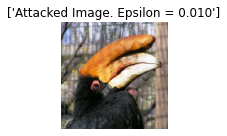

Actual Class: n02018207.JPEG [[('n02018207', 'American_coot', 0.9624756)]]
Class for Attacked Image: [('n02018207', 'American_coot', 0.05606244)]


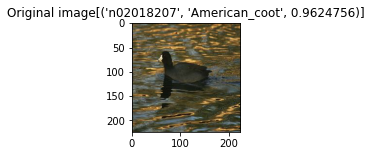

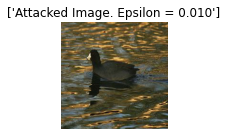

Actual Class: n04131690.JPEG [[('n04131690', 'saltshaker', 0.78751045)]]
Class for Attacked Image: [('n03544143', 'hourglass', 0.1344423)]


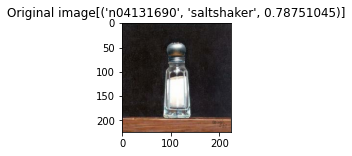

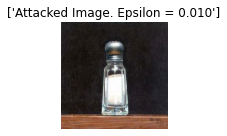

Actual Class: n02815834.JPEG [[('n02815834', 'beaker', 0.9825494)]]
Class for Attacked Image: [('n02815834', 'beaker', 0.29528555)]


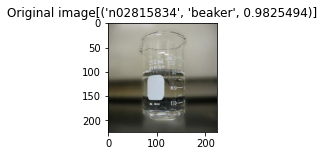

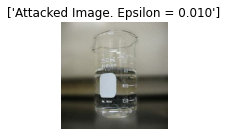

Actual Class: n03485407.JPEG [[('n03485407', 'hand-held_computer', 0.91214824)]]
Class for Attacked Image: [('n04264628', 'space_bar', 0.13035674)]


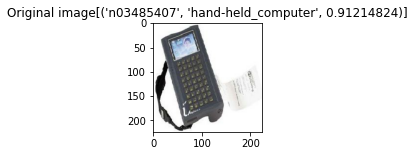

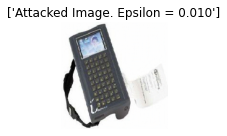

Actual Class: n03467068.JPEG [[('n03467068', 'guillotine', 0.2443353)]]
Class for Attacked Image: [('n04070727', 'refrigerator', 0.16208899)]


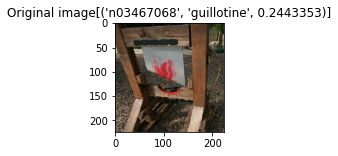

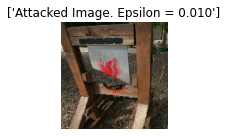

Actual Class: n04311174.JPEG [[('n04311174', 'steel_drum', 0.8753987)]]
Class for Attacked Image: [('n03786901', 'mortar', 0.058509115)]


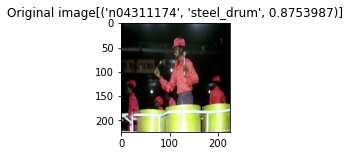

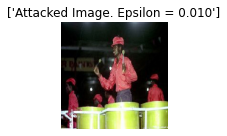

Actual Class: n04065272.JPEG [[('n04065272', 'recreational_vehicle', 0.79198074)]]
Class for Attacked Image: [('n04389033', 'tank', 0.04898627)]


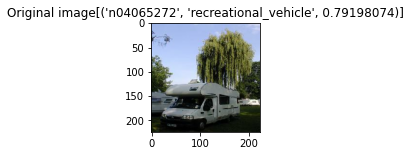

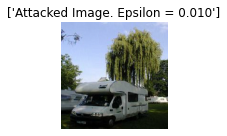

Actual Class: n03794056.JPEG [[('n03794056', 'mousetrap', 0.90010774)]]
Class for Attacked Image: [('n03109150', 'corkscrew', 0.08101935)]


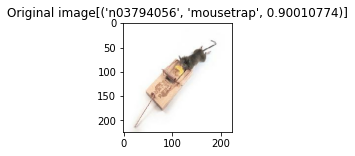

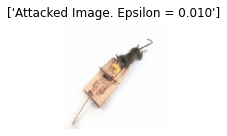

Actual Class: n04376876.JPEG [[('n04376876', 'syringe', 0.90011245)]]
Class for Attacked Image: [('n02692877', 'airship', 0.6773812)]


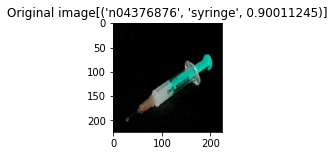

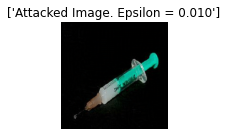

Actual Class: n03379051.JPEG [[('n03379051', 'football_helmet', 0.99002975)]]
Class for Attacked Image: [('n02817516', 'bearskin', 0.09842361)]


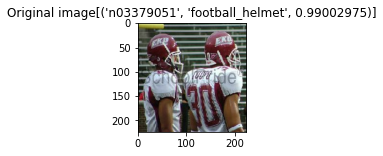

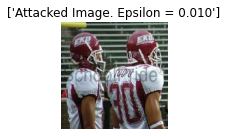

Actual Class: n02071294.JPEG [[('n02071294', 'killer_whale', 0.98996603)]]
Class for Attacked Image: [('n01484850', 'great_white_shark', 0.09176363)]


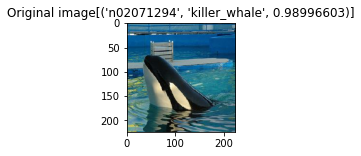

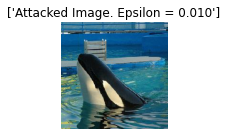

Actual Class: n03424325.JPEG [[('n03424325', 'gasmask', 0.9075357)]]
Class for Attacked Image: [('n03868863', 'oxygen_mask', 0.095023684)]


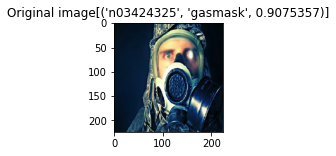

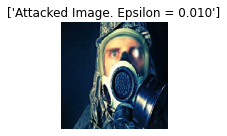

Actual Class: n03216828.JPEG [[('n03216828', 'dock', 0.8677406)]]
Class for Attacked Image: [('n03947888', 'pirate', 0.14045276)]


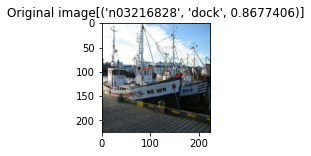

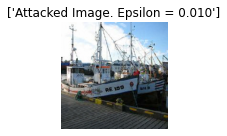

Actual Class: n07836838.JPEG [[('n07836838', 'chocolate_sauce', 0.39618567)]]
Class for Attacked Image: [('n07717410', 'acorn_squash', 0.39799076)]


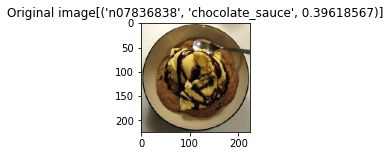

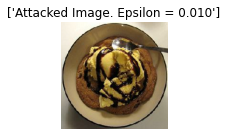

Actual Class: n03201208.JPEG [[('n03201208', 'dining_table', 0.9424228)]]
Class for Attacked Image: [('n04099969', 'rocking_chair', 0.65386844)]


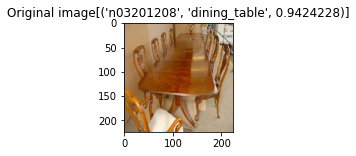

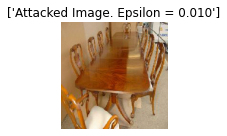

Actual Class: n12267677.JPEG [[('n12267677', 'acorn', 0.99733424)]]
Class for Attacked Image: [('n13040303', 'stinkhorn', 0.09727846)]


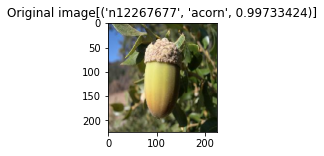

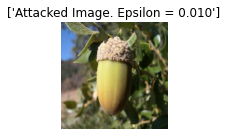

Actual Class: n02769748.JPEG [[('n02769748', 'backpack', 0.99261343)]]
Class for Attacked Image: [('n03617480', 'kimono', 0.30538538)]


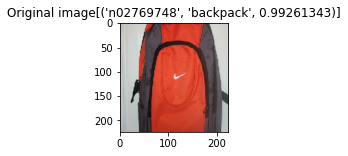

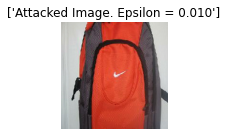

Actual Class: n07583066.JPEG [[('n07583066', 'guacamole', 0.9541079)]]
Class for Attacked Image: [('n07714571', 'head_cabbage', 0.32669345)]


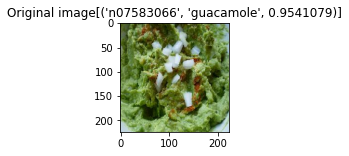

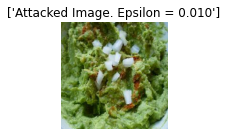

Actual Class: n02012849.JPEG [[('n02012849', 'crane', 0.8706828)]]
Class for Attacked Image: [('n01855672', 'goose', 0.32697707)]


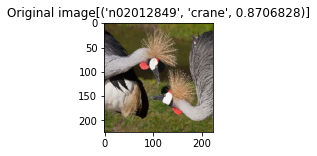

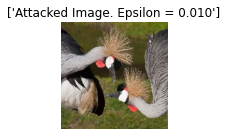

Actual Class: n01530575.JPEG [[('n01530575', 'brambling', 0.6741143)]]
Class for Attacked Image: [('n01534433', 'junco', 0.55582297)]


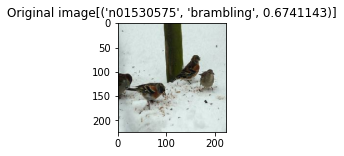

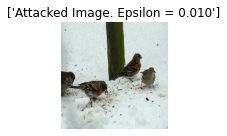

Actual Class: n04597913.JPEG [[('n04597913', 'wooden_spoon', 0.64943933)]]
Class for Attacked Image: [('n02966687', "carpenter's_kit", 0.09840319)]


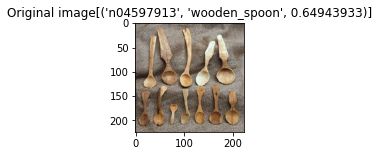

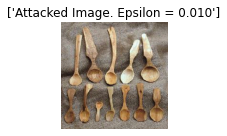

Actual Class: n02480495.JPEG [[('n02480495', 'orangutan', 0.93499786)]]
Class for Attacked Image: [('n02074367', 'dugong', 0.07482691)]


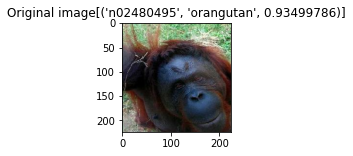

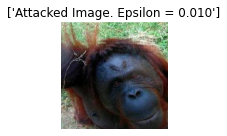

Actual Class: n02791270.JPEG [[('n02791270', 'barbershop', 0.6134175)]]
Class for Attacked Image: [('n03992509', "potter's_wheel", 0.15368775)]


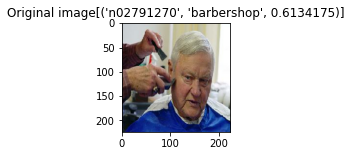

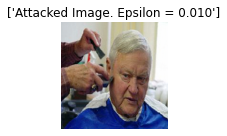

Actual Class: n04251144.JPEG [[('n04251144', 'snorkel', 0.88256764)]]
Class for Attacked Image: [('n02837789', 'bikini', 0.18431203)]


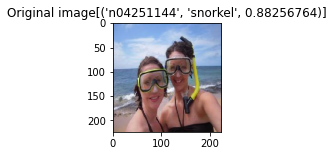

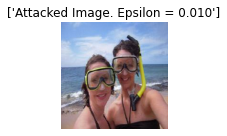

Actual Class: n02966687.JPEG [[('n02966687', "carpenter's_kit", 0.59368783)]]
Class for Attacked Image: [('n03014705', 'chest', 0.17359947)]


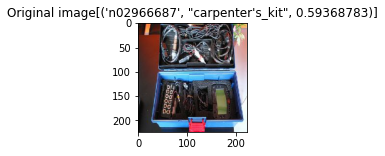

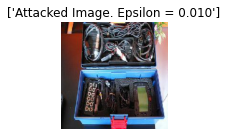

Actual Class: n04153751.JPEG [[('n04153751', 'screw', 0.9988856)]]
Class for Attacked Image: [('n03843555', 'oil_filter', 0.22584258)]


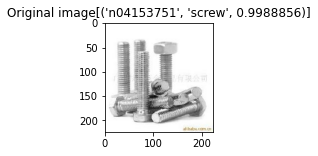

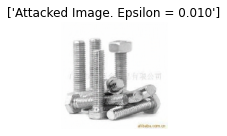

Actual Class: n02794156.JPEG [[('n02794156', 'barometer', 0.870986)]]
Class for Attacked Image: [('n04523525', 'vault', 0.6920305)]


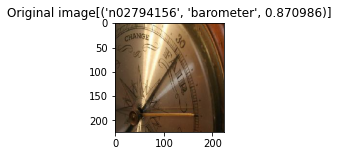

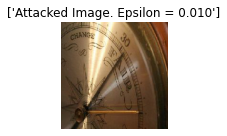

Actual Class: n02814860.JPEG [[('n02814860', 'beacon', 0.9072195)]]
Class for Attacked Image: [('n04009552', 'projector', 0.18625171)]


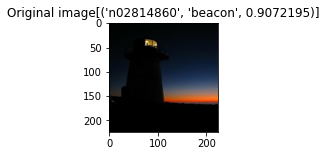

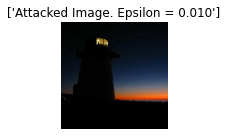

Actual Class: n02013706.JPEG [[('n02013706', 'limpkin', 0.9049722)]]
Class for Attacked Image: [('n01518878', 'ostrich', 0.054469556)]


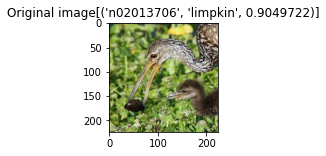

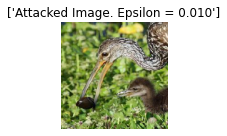

Actual Class: n04026417.JPEG [[('n04026417', 'purse', 0.88349587)]]
Class for Attacked Image: [('n02769748', 'backpack', 0.1573355)]


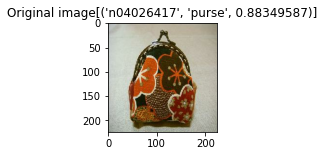

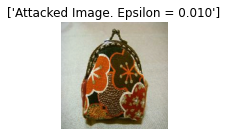

Actual Class: n01688243.JPEG [[('n01688243', 'frilled_lizard', 0.9871198)]]
Class for Attacked Image: [('n02206856', 'bee', 0.054792218)]


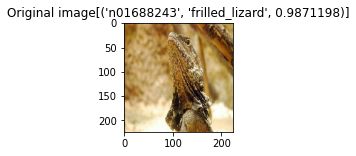

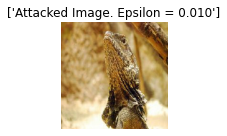

Actual Class: n01537544.JPEG [[('n01537544', 'indigo_bunting', 0.9573629)]]
Class for Attacked Image: [('n02825657', 'bell_cote', 0.26591623)]


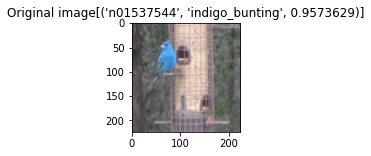

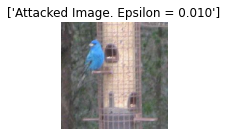

Actual Class: n03016953.JPEG [[('n03016953', 'chiffonier', 0.9749452)]]
Class for Attacked Image: [('n03016953', 'chiffonier', 0.48105448)]


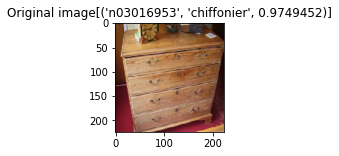

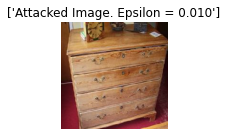

Actual Class: n04525038.JPEG [[('n04525038', 'velvet', 0.36390582)]]
Class for Attacked Image: [('n07768694', 'pomegranate', 0.25643092)]


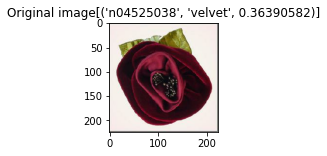

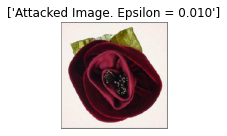

Actual Class: n02107908.JPEG [[('n02106550', 'Rottweiler', 0.129098)]]
Class for Attacked Image: [('n02091134', 'whippet', 0.12785864)]


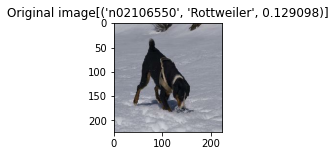

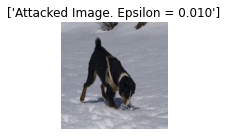

Actual Class: n03131574.JPEG [[('n03131574', 'crib', 0.935974)]]
Class for Attacked Image: [('n03125729', 'cradle', 0.57191336)]


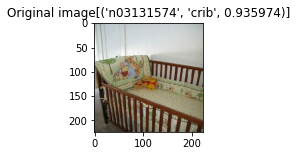

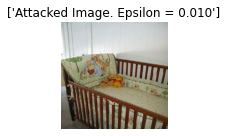

Actual Class: n04493381.JPEG [[('n04493381', 'tub', 0.79675317)]]
Class for Attacked Image: [('n02536864', 'coho', 0.2532204)]


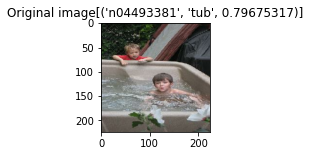

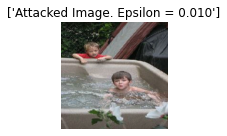

Actual Class: n02110185.JPEG [[('n02110185', 'Siberian_husky', 0.43833995)]]
Class for Attacked Image: [('n02097474', 'Tibetan_terrier', 0.52336115)]


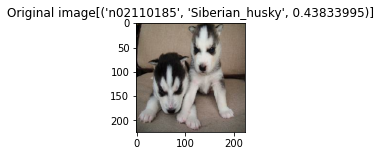

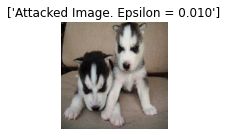

Actual Class: n02229544.JPEG [[('n02229544', 'cricket', 0.49820185)]]
Class for Attacked Image: [('n02879718', 'bow', 0.5686167)]


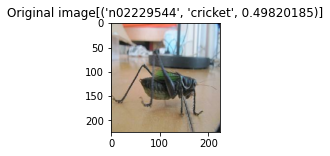

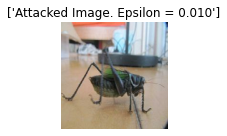

Actual Class: n02422106.JPEG [[('n02422106', 'hartebeest', 0.9804503)]]
Class for Attacked Image: [('n02437616', 'llama', 0.35848913)]


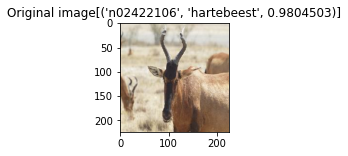

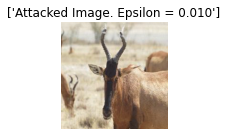

Actual Class: n03977966.JPEG [[('n03977966', 'police_van', 0.8936149)]]
Class for Attacked Image: [('n04037443', 'racer', 0.059190165)]


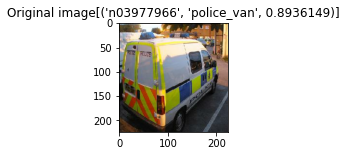

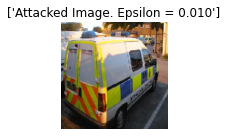

Actual Class: n02667093.JPEG [[('n02667093', 'abaya', 0.97641045)]]
Class for Attacked Image: [('n03617480', 'kimono', 0.6248306)]


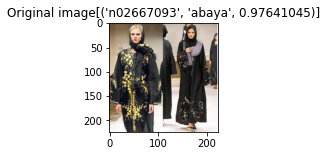

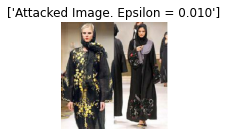

Actual Class: n03721384.JPEG [[('n03721384', 'marimba', 0.9895936)]]
Class for Attacked Image: [('n03876231', 'paintbrush', 0.15845445)]


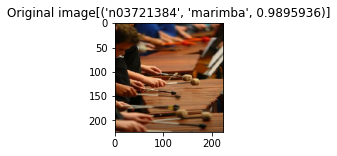

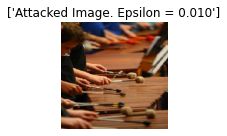

Actual Class: n12144580.JPEG [[('n12144580', 'corn', 0.8418187)]]
Class for Attacked Image: [('n07753113', 'fig', 0.42153004)]


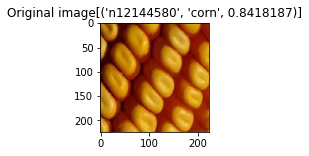

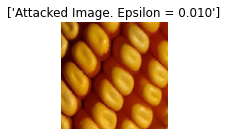

Actual Class: n02099267.JPEG [[('n02099267', 'flat-coated_retriever', 0.9158305)]]
Class for Attacked Image: [('n02109047', 'Great_Dane', 0.32792637)]


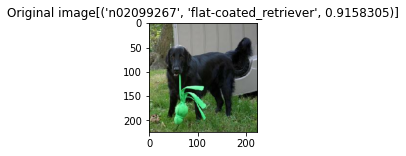

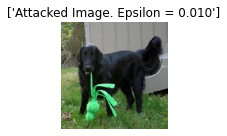

Actual Class: n03673027.JPEG [[('n03673027', 'liner', 0.90292484)]]
Class for Attacked Image: [('n04347754', 'submarine', 0.99756193)]


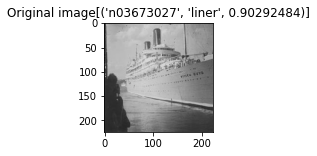

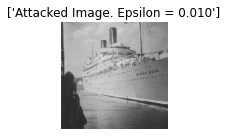

Actual Class: n02443114.JPEG [[('n02443114', 'polecat', 0.4432632)]]
Class for Attacked Image: [('n02361337', 'marmot', 0.49984998)]


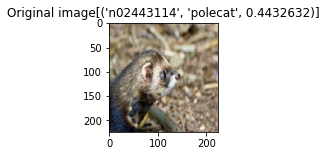

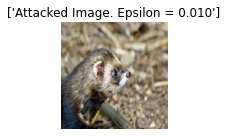

Actual Class: n03197337.JPEG [[('n03197337', 'digital_watch', 0.5685444)]]
Class for Attacked Image: [('n02910353', 'buckle', 0.897256)]


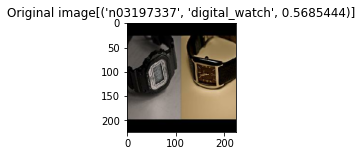

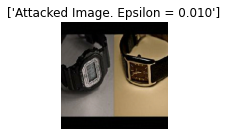

Actual Class: n07695742.JPEG [[('n07695742', 'pretzel', 0.23293774)]]
Class for Attacked Image: [('n07584110', 'consomme', 0.18728329)]


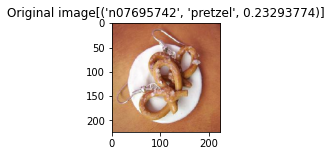

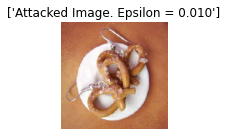

Actual Class: n01817953.JPEG [[('n01817953', 'African_grey', 0.38135117)]]
Class for Attacked Image: [('n01665541', 'leatherback_turtle', 0.07760219)]


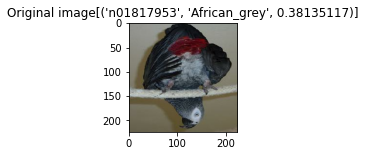

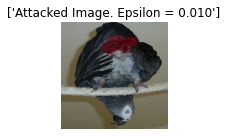

Actual Class: n03393912.JPEG [[('n03393912', 'freight_car', 0.97036195)]]
Class for Attacked Image: [('n02892201', 'brass', 0.052116875)]


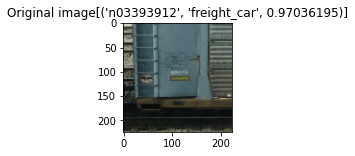

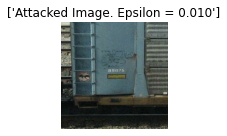

Actual Class: n02790996.JPEG [[('n02790996', 'barbell', 0.6888848)]]
Class for Attacked Image: [('n03452741', 'grand_piano', 0.098513156)]


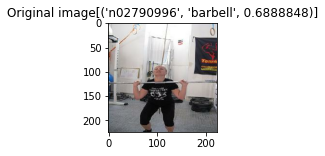

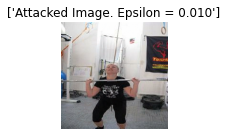

Actual Class: n02777292.JPEG [[('n02777292', 'balance_beam', 0.76994765)]]
Class for Attacked Image: [('n03710721', 'maillot', 0.14910187)]


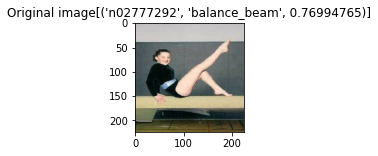

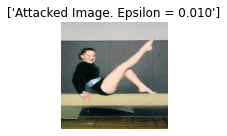

Actual Class: n03584254.JPEG [[('n03584254', 'iPod', 0.23052451)]]
Class for Attacked Image: [('n02808440', 'bathtub', 0.21510334)]


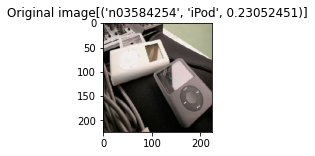

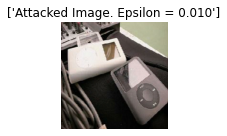

Actual Class: n02177972.JPEG [[('n02177972', 'weevil', 0.87587696)]]
Class for Attacked Image: [('n01776313', 'tick', 0.3484992)]


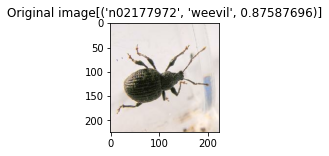

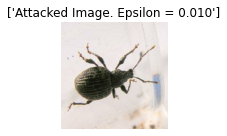

Actual Class: n02093256.JPEG [[('n02093256', 'Staffordshire_bullterrier', 0.60437506)]]
Class for Attacked Image: [('n02110627', 'affenpinscher', 0.61212903)]


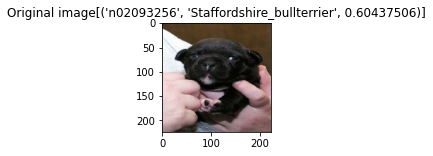

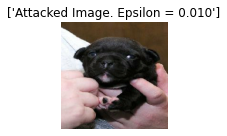

Actual Class: n01664065.JPEG [[('n01664065', 'loggerhead', 0.6575961)]]
Class for Attacked Image: [('n01644900', 'tailed_frog', 0.17029825)]


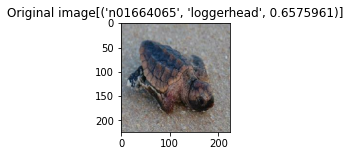

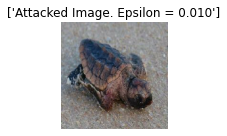

Actual Class: n03042490.JPEG [[('n03042490', 'cliff_dwelling', 0.28317738)]]
Class for Attacked Image: [('n01601694', 'water_ouzel', 0.44076946)]


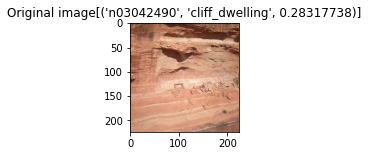

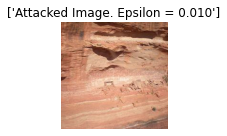

Actual Class: n03000134.JPEG [[('n03000134', 'chainlink_fence', 0.627445)]]
Class for Attacked Image: [('n02423022', 'gazelle', 0.20074296)]


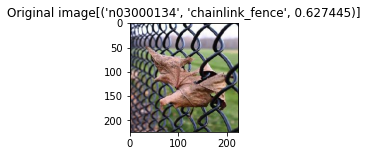

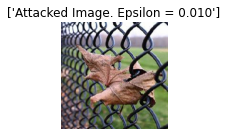

Actual Class: n02033041.JPEG [[('n02033041', 'dowitcher', 0.8923282)]]
Class for Attacked Image: [('n02028035', 'redshank', 0.23574758)]


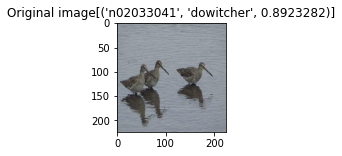

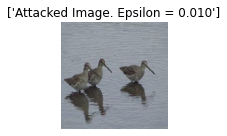

Actual Class: n03956157.JPEG [[('n03956157', 'planetarium', 0.5038202)]]
Class for Attacked Image: [('n02398521', 'hippopotamus', 0.33034563)]


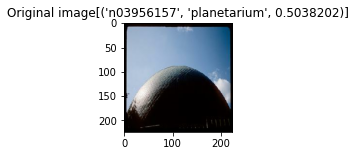

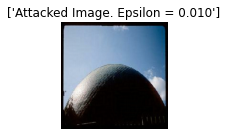

Actual Class: n03394916.JPEG [[('n03394916', 'French_horn', 0.7087139)]]
Class for Attacked Image: [('n02865351', 'bolo_tie', 0.24843116)]


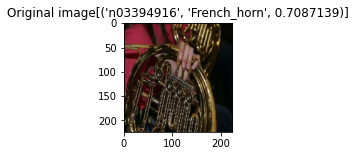

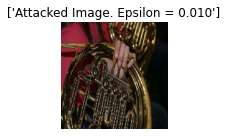

Actual Class: n02110341.JPEG [[('n02110341', 'dalmatian', 0.9106462)]]
Class for Attacked Image: [('n03838899', 'oboe', 0.30513763)]


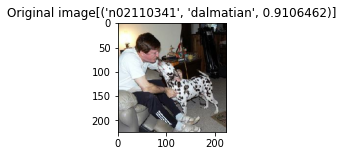

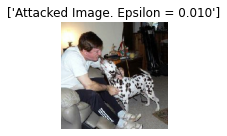

Actual Class: n02259212.JPEG [[('n02259212', 'leafhopper', 0.94916165)]]
Class for Attacked Image: [('n02906734', 'broom', 0.11194155)]


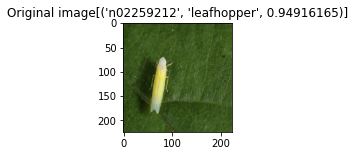

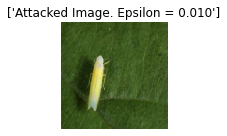

Actual Class: n02093647.JPEG [[('n02093647', 'Bedlington_terrier', 0.8137123)]]
Class for Attacked Image: [('n02134084', 'ice_bear', 0.042512022)]


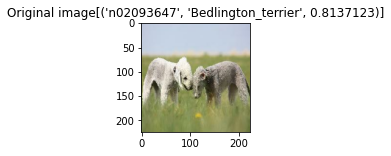

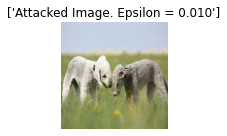

Actual Class: n02489166.JPEG [[('n02489166', 'proboscis_monkey', 0.9693718)]]
Class for Attacked Image: [('n02493793', 'spider_monkey', 0.24273068)]


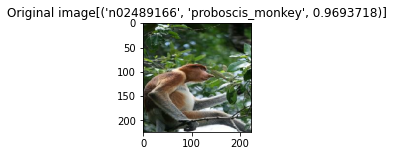

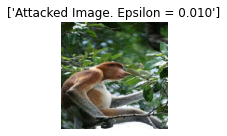

In [19]:
#change directory into file structure
%cd '/content/drive/My Drive/Uni Assignments/SIT799 Human Aligned AI/Task_4/input_dir'

#Execute loop for all images in input directory
for idx2label in image_files_collection[:100]:
  #preprocess the image 
  image_raw = tf.io.read_file(idx2label)
  image = tf.image.decode_png(image_raw)
  input_image = preprocess(image)
  reversed_image = reverse_preprocess(input_image)
  input_image_placeholder = tf.placeholder(shape=[1, 224, 224, 3], dtype=tf.float32)
  pretrained_model = nets.MobileNet50v2(input_image_placeholder, reuse=tf.AUTO_REUSE)
  pretrained_ops = pretrained_model.pretrained()
  decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions
  preprocessed_img, reversed_img = sess.run([input_image, reversed_image])
  image_probs = sess.run([pretrained_model], {input_image_placeholder:preprocessed_img})
  top5 = get_imagenet_label(image_probs[0])
  tick_names = [x[1] for x in top5]

  # Print the actual class for the image
  print('Actual Class:', idx2label, decode_predictions(image_probs[0], top=1))
  decode_preds = decode_predictions(image_probs[0], top=1)
  listToStr = ' '.join([str(elem) for elem in decode_preds])
  plt.figure(figsize=(8, 2))
  plt.subplot(121)
  #ax.axis('off')
  plt.imshow(reversed_img[0])
  plt.title('Original image' + listToStr) # Plot original image with class labels
  ax = plt.gca()
  #append predicted values to output
  output.append(listToStr)

  #Create the pertubations
  perturbations = create_adversarial_pattern(input_image_placeholder, tf.argmax(pretrained_model,1))

  def display_images(image, description):
    rev_image = reverse_preprocess(image)
    adv_img, raw_adv_img = sess.run([image, rev_image], {input_image_placeholder: preprocessed_img})
    img_probs = sess.run(pretrained_model, {input_image_placeholder: adv_img})
    decode_preds2 = decode_predictions(img_probs, top=1)
    listToStr2 = ' '.join([str(elem) for elem in decode_preds2])
    print('Class for Attacked Image: ' + listToStr2)
    #Store outputs
    output2.append(listToStr2)

    #plot figures
    plt.figure(figsize=(8, 2))
    plt.subplot(122)
    plt.imshow(raw_adv_img[0])
    plt.title(description)
    plt.gca().axis('off')
    plt.tight_layout()
    plt.show()

  #Generate the adverse images:
  description = ['Attacked Image. Epsilon = {:0.3f}'.format(epsilon)]
  adv_x = input_image + epsilon*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, description)

In [20]:
#Setup results captured for comparison
columns = ['FileName', 'label','probability']
Output_Actuals = [[str(x) for x in e.split(',')] for e in output]
Output_Actuals_df = pd.DataFrame(Output_Actuals, columns=columns)

Output_Attacks = [[str(x) for x in e.split(',')] for e in output2]
Output_Attacks_df = pd.DataFrame(Output_Attacks, columns=columns)

Actuals_label = Output_Actuals_df['label']
Attacks_label = Output_Attacks_df['label']

In [21]:
#Calculate the success rate and show the equality status for each image record
Results1 = pd.concat([Actuals_label, Attacks_label], axis=1, keys=['actual', 'attack'])
Comparison = np.where(Results1["actual"] == Results1["attack"], True, False)
Results1["equal"] = Comparison
Results1

actual                           attack  equal
0                        'forklift'                  'china_cabinet'  False
1    'black_and_gold_garden_spider'   'black_and_gold_garden_spider'   True
2                           'wreck'                         'briard'  False
3                        'lakeside'                'Norfolk_terrier'  False
4                          'paddle'                   'killer_whale'  False
..                              ...                              ...    ...
95                    'French_horn'                       'bolo_tie'  False
96                      'dalmatian'                           'oboe'  False
97                     'leafhopper'                          'broom'  False
98             'Bedlington_terrier'                       'ice_bear'  False
99               'proboscis_monkey'                  'spider_monkey'  False

[100 rows x 3 columns]

In [22]:
true_count = sum(Results1["equal"])
successful = (100-true_count) #the total number of images minus the number of actuals matching attack classes
print("Total number of successfully attacked images: ", successful)

Total number of successfully attacked images:  95


# Part 3

Open question: Can you implement another computer vision adversarial method? You can try the "Targeted Fast Gradient Sign Method (T-FGSM)". Please do so and document your code.


In [39]:
#Code adapted from: https://harvard-iacs.github.io/2019-CS109B/lecture/lab21/AdversarialNN/
# Alternative method will describe how to perform a JSMA attack on an
# image classification neural network model.
# Using MNIST dataset, load data via keras
import requests
import numpy as np
from keras.datasets import mnist
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
session = tf.compat.v1.Session()
keras.backend.set_session(session)

In [40]:
#Load in the MNIST dataset
(mn_x_train, mn_y_train), (mn_x_test, mn_y_test) = mnist.load_data()

In [41]:
#Check the training examples
print ("Training Examples: %d" % len(mn_x_train))
print ("Test Examples: %d" % len(mn_x_test))

Training Examples: 60000
Test Examples: 10000


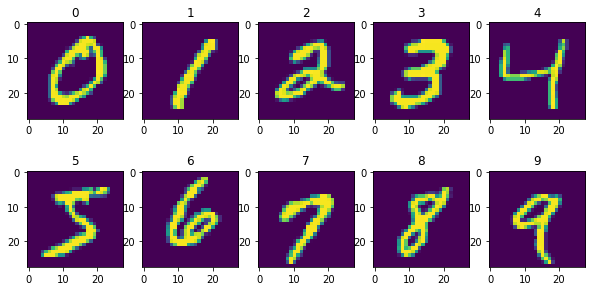

In [42]:
#Observe the digits in the dataset. There are 10 classes for classification.
n_classes = 10
inds=np.array([mn_y_train==i for i in range(n_classes)])
f,ax=plt.subplots(2,5,figsize=(10,5))
ax=ax.flatten()
for i in range(n_classes):
    ax[i].imshow(mn_x_train[np.argmax(inds[i])].reshape(28,28))
    ax[i].set_title(str(i))
plt.show()

In [43]:
#Setup to train a neural network
from keras import models
from keras import layers
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

#Training data
train_images_1d = mn_x_train.reshape((60000, 28 * 28))
train_images_1d = train_images_1d.astype('float32') / 255

#Testing data
test_images_1d = mn_x_test.reshape((10000, 28 * 28))
test_images_1d = test_images_1d.astype('float32') / 255

#convert the labels to one hot encoded values
from tensorflow.keras.utils import to_categorical 
train_labels = to_categorical(mn_y_train)
test_labels = to_categorical(mn_y_test)

In [ ]:
#Train the model
from keras.callbacks import ModelCheckpoint
h=network.fit(train_images_1d, 
              train_labels, 
              epochs=1,
              batch_size=128, 
              shuffle=True)

In [ ]:
# Implement a JSMA attack method. This generates targeted examples.
# The Jacobian-based Saliency Map Attack (JSMA) is a family of adversarial attack methods
# for fooling classification models, such as deep neural networks for image classification tasks.
# On the MNIST dataset, for example where the target class is digit '4' JSMA
# can pertub the image to confuse the model into predicting it as digit '0' or digit '9'.
# Reference:  https://arxiv.org/abs/1511.07528, Papernot, N. et al 
# "The Limitations of Deep Learning in Adversarial Settings" (2015)

x = tf.placeholder(tf.float32, shape=(None, 784))
y = tf.placeholder(tf.float32, shape=(None, 10))

#Setup the pertubations
#create the elements in the TensorFlow graph necessary to compute Jacobian matrices 
results = np.zeros((10, 10000)) # indicate whether an adversarial example was found for each
perturbations = np.zeros((10, 10000)) #fraction of perturbed features for each test set
grid_shape = (10, 10, 28, 28, 1)
grid_data = np.zeros(grid_shape)

#Use the SaliencyMapMethod from the cleverhans library
from cleverhans.attacks import SaliencyMapMethod
jsma = SaliencyMapMethod(wrap, sess=session)

jsma_params = {'theta': 1., 
               'gamma': 0.1,
               'clip_min': 0., 
               'clip_max': 1.,
               'y_target': None}

from cleverhans.utils import other_classes, grid_visual

# Loop over the samples we want to perturb into adversarial examples
for index in range(int(len(mn_x_test) / 100)):
    sample = test_images_1d[index: index + 1]
    current = mn_y_test[index]
    target_classes = other_classes(10, current)
    grid_data[current, current, :, :, :] = np.reshape(
            sample, (28, 28, 1))
    # Loop over all target classes
    for target in target_classes:
        one_hot_target = np.zeros((1, 10))
        one_hot_target[0, target] = 1
        jsma_params['y_target'] = one_hot_target
        #Runs the Jacobian-based saliency map approach
        adv_x = jsma.generate_np(sample, **jsma_params)
        
        # Update the grid for later analysis
        grid_data[target, current, :, :, :] = np.reshape(
                adv_x, (28, 28, 1))
        
 #Each row in the matrix of values will correspond to a specific starting
 #digit class. The JSMA method will generate adversarial examples that are designed
 #to be predicted as either 0,1 where each column of the matrix represents
 #the advanced adversarial target class. 

    if index % 10 == 0:
        print(index)
        print(sample.shape)
        print(one_hot_target)
        print(adv_x.shape)

# Congratulations!

You've come to the end of this assignment, and have seen a lot of the ways attack and fool an AI system. Here are the main points you should remember:

- It is very easy to fool a computer vision system if you know the model and its parameters.
- When designing an AI system, you need to think of adverse attacks againsts your system.

Congratulations on finishing this notebook! 



In [ ]:
#!jupyter nbconvert --to pdf 'YOUR_LINK_TO_THE_IPYNOTE_NOTEBOOK'